In [2]:
import yfinance as yf
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

In [3]:
UNIVERSE = "sp500"

if UNIVERSE == "russell_3000":
    url = "https://www.kibot.com/Historical_Data/Russell_3000_Historical_Tick_Data.aspx"
    table_index = 1
elif UNIVERSE == "sp500":
    url = "https://stockanalysis.com/list/sp-500-stocks/"
    table_index = 0

ticker_list = pd.read_html(url)[table_index]
filename = f"{UNIVERSE}_historical.csv"

In [ ]:
all_data = []

for ticker in ticker_list["Symbol"]:
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        historical = stock.history(period="10y")
        historical["Ticker"] = ticker
        historical["Industry"] = info.get("industry")
        historical["Sector"] = info.get("sector")
        historical["MarketCap"] = info.get("marketCap")
        all_data.append(historical)
    except Exception as e:
        print(f"{ticker}: Failed - {e}")

historical_df = pd.concat(all_data)
historical_df = historical_df.reset_index()  # moves Date from index to column
historical_df.to_csv(filename)


In [ ]:
print(f"Tickers: {historical_df['Ticker'].nunique()}")
print(f"Total rows: {len(historical_df)}")

In [32]:
# load from a pre-saved dataframe.
historical_df = pd.read_csv("sp500_historical.csv")

# benchmark: SP500 SPY ETF
spy = yf.Ticker("SPY") 
spy_hist = spy.history(period="10y", interval = "1mo")


In [33]:
# data cleanup
historical_df["Date"] = pd.to_datetime(historical_df["Date"], utc=True) # Standardize format for pandas
dropped_columns = ["Open","High","Low","Volume","Dividends","Stock Splits","Adj Close"]
historical_df = historical_df.drop(dropped_columns, axis=1)

In [34]:
# set up the data for momentum returns
historical_df["YearMonth"] = historical_df["Date"].dt.to_period("M") # standardizes data into monthly format 
monthly_data = historical_df.groupby(["YearMonth", "Ticker"]).last() # drops all other days and just keeps last day of each month.
monthly_data = monthly_data.reset_index()
monthly_data["Return"] = monthly_data.groupby("Ticker")["Close"].pct_change()
monthly_data

/var/folders/pl/r7xmw3dj49j5xmdjjwtznvcr0000gn/T/ipykernel_33683/4037181897.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  historical_df["YearMonth"] = historical_df["Date"].dt.to_period("M") # standardizes data into monthly format


,YearMonth,Ticker,Unnamed: 0,Date,Close,Industry,Sector,MarketCap,Return
0,2015-12,A,563976,2015-12-31 05:00:00+00:00,38.672306,Diagnostics & Research,Healthcare,42553413632,NaN
1,2015-12,AAPL,2534,2015-12-31 05:00:00+00:00,23.732859,Consumer Electronics,Technology,4201314516992,NaN
2,2015-12,ABBV,49085,2015-12-31 05:00:00+00:00,39.086403,Drug Manufacturers - General,Healthcare,397855948800,NaN
3,2015-12,ABT,101880,2015-12-31 05:00:00+00:00,37.199482,Medical Devices,Healthcare,222796152832,NaN
4,2015-12,ACGL,674253,2015-12-31 05:00:00+00:00,22.108391,Insurance - Diversified,Financial Services,34769203200,NaN
...,...,...,...,...,...,...,...,...,...
58734,2025-12,XYZ,596637,2025-12-01 05:00:00+00:00,64.349998,Software - Infrastructure,Technology,39226728448,-0.036677
58735,2025-12,YUM,579039,2025-12-01 05:00:00+00:00,150.639999,Restaurants,Consumer Cyclical,41825624064,-0.016774
58736,2025-12,ZBH,953152,2025-12-01 05:00:00+00:00,94.760002,Medical Devices,Healthcare,18779684864,-0.028302
58737,2025-12,ZBRA,1100658,2025-12-01 05:00:00+00:00,251.289993,Communication Equipment,Technology,12730411008,-0.005776


In [35]:
# calculate momentum
def calc_momentum(returns):
    growth_factor = 1 + returns # set up returns for compounding
    rolling_return = growth_factor.rolling(11).apply(lambda x: x.prod()) - 1 # for each growth factor, multiply it to the previous 11 months and return the %
    return rolling_return.shift(1) # want the previous 11 months, up to the most recent to avoid recent shocks 

monthly_data["Momentum"] = monthly_data.groupby('Ticker')['Return'].transform(calc_momentum) 
monthly_data.dropna()


,YearMonth,Ticker,Unnamed: 0,Date,Close,Industry,Sector,MarketCap,Return,Momentum
5596,2016-12,A,564228,2016-12-30 05:00:00+00:00,42.602474,Diagnostics & Research,Healthcare,42553413632,0.038925,0.060353
5597,2016-12,AAPL,2786,2016-12-30 05:00:00+00:00,26.694824,Consumer Electronics,Technology,4201314516992,0.047955,0.073332
5598,2016-12,ABBV,49337,2016-12-30 05:00:00+00:00,42.913723,Drug Manufacturers - General,Healthcare,397855948800,0.029934,0.066009
5599,2016-12,ABT,102132,2016-12-30 05:00:00+00:00,32.616276,Medical Devices,Healthcare,222796152832,0.008931,-0.130968
5600,2016-12,ACGL,674505,2016-12-30 05:00:00+00:00,27.351011,Insurance - Diversified,Financial Services,34769203200,0.043158,0.185950
...,...,...,...,...,...,...,...,...,...,...
58734,2025-12,XYZ,596637,2025-12-01 05:00:00+00:00,64.349998,Software - Infrastructure,Technology,39226728448,-0.036677,-0.214025
58735,2025-12,YUM,579039,2025-12-01 05:00:00+00:00,150.639999,Restaurants,Consumer Cyclical,41825624064,-0.016774,0.158616
58736,2025-12,ZBH,953152,2025-12-01 05:00:00+00:00,94.760002,Medical Devices,Healthcare,18779684864,-0.028302,-0.070130
58737,2025-12,ZBRA,1100658,2025-12-01 05:00:00+00:00,251.289993,Communication Equipment,Technology,12730411008,-0.005776,-0.345580


In [36]:
# for each month, group by deciles
monthly_data["Ranking"] = monthly_data.groupby(["YearMonth"])["Momentum"].rank()


In [37]:
def get_decile_rank(ranking):
    decile_rank = pd.qcut(ranking, q=10, duplicates="drop", labels=False)
    return decile_rank
monthly_data["Decile Ranking"] = monthly_data.groupby("YearMonth")["Ranking"].transform(get_decile_rank)
monthly_data


,YearMonth,Ticker,Unnamed: 0,Date,Close,Industry,Sector,MarketCap,Return,Momentum,Ranking,Decile Ranking
0,2015-12,A,563976,2015-12-31 05:00:00+00:00,38.672306,Diagnostics & Research,Healthcare,42553413632,NaN,NaN,NaN,NaN
1,2015-12,AAPL,2534,2015-12-31 05:00:00+00:00,23.732859,Consumer Electronics,Technology,4201314516992,NaN,NaN,NaN,NaN
2,2015-12,ABBV,49085,2015-12-31 05:00:00+00:00,39.086403,Drug Manufacturers - General,Healthcare,397855948800,NaN,NaN,NaN,NaN
3,2015-12,ABT,101880,2015-12-31 05:00:00+00:00,37.199482,Medical Devices,Healthcare,222796152832,NaN,NaN,NaN,NaN
4,2015-12,ACGL,674253,2015-12-31 05:00:00+00:00,22.108391,Insurance - Diversified,Financial Services,34769203200,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
58734,2025-12,XYZ,596637,2025-12-01 05:00:00+00:00,64.349998,Software - Infrastructure,Technology,39226728448,-0.036677,-0.214025,47.0,0.0
58735,2025-12,YUM,579039,2025-12-01 05:00:00+00:00,150.639999,Restaurants,Consumer Cyclical,41825624064,-0.016774,0.158616,311.0,6.0
58736,2025-12,ZBH,953152,2025-12-01 05:00:00+00:00,94.760002,Medical Devices,Healthcare,18779684864,-0.028302,-0.070130,130.0,2.0
58737,2025-12,ZBRA,1100658,2025-12-01 05:00:00+00:00,251.289993,Communication Equipment,Technology,12730411008,-0.005776,-0.345580,17.0,0.0


In [38]:
# Who are most recent winners?
monthly_data[(monthly_data["Decile Ranking"] == 9) & (monthly_data["YearMonth"] == "2016-11")].sort_values("Momentum", ascending=False)

,YearMonth,Ticker,Unnamed: 0,Date,Close,Industry,Sector,MarketCap,Return,Momentum,Ranking,Decile Ranking


In [39]:
# Who are most recent momentum losers?
monthly_data[(monthly_data["Decile Ranking"] == 0) & (monthly_data["YearMonth"] == "2025-11")].sort_values("Momentum", ascending=True)

,YearMonth,Ticker,Unnamed: 0,Date,Close,Industry,Sector,MarketCap,Return,Momentum,Ranking,Decile Ranking
57922,2025-11,FISV,674231,2025-11-28 05:00:00+00:00,61.470001,None,None,34077853696,-0.078273,-0.698181,1.0,0.0
58186,2025-11,TTD,948123,2025-11-28 05:00:00+00:00,39.560001,Advertising Agencies,Communication Services,19352360960,-0.213206,-0.608868,2.0,0.0
57865,2025-11,DECK,1073003,2025-11-28 05:00:00+00:00,88.029999,Footwear & Accessories,Consumer Cyclical,13650555904,0.080123,-0.584099,3.0,0.0
57984,2025-11,IT,1017247,2025-11-28 05:00:00+00:00,232.740005,Information Technology Services,Technology,17478305792,-0.062817,-0.520514,4.0,0.0
58046,2025-11,MOH,1217246,2025-11-28 05:00:00+00:00,148.259995,Healthcare Plans,Healthcare,7858999808,-0.031360,-0.486203,5.0,0.0
57831,2025-11,CMG,544716,2025-11-28 05:00:00+00:00,34.520000,Restaurants,Consumer Cyclical,45911904256,0.089303,-0.484883,6.0,0.0
58020,2025-11,LULU,893017,2025-11-28 05:00:00+00:00,184.179993,Apparel Retail,Consumer Cyclical,21861931008,0.079981,-0.468159,7.0,0.0
57916,2025-11,FDS,1155362,2025-11-28 05:00:00+00:00,277.269989,Financial Data & Stock Exchanges,Financial Services,10370187264,0.043380,-0.452113,8.0,0.0
57790,2025-11,BAX,1162904,2025-11-28 05:00:00+00:00,18.740000,Medical Instruments & Supplies,Healthcare,9808184320,0.015155,-0.442475,9.0,0.0
58156,2025-11,STZ,832680,2025-11-28 05:00:00+00:00,136.380005,Beverages - Brewers,Consumer Defensive,23998576640,0.038058,-0.440901,10.0,0.0


In [40]:
# Momentum strategy: all stocks
# Idea: for every month, rank the top momentum winners (Decile 9), and rank the top momentum losers (Decile 0)
# For the upcomming month, go LONG the winners and SHORT the losers
# The following month, track return from portfolio, and rerank stocks.

# Notes: this is all decile 9 and 0 ranks, not accounting for industry bias (we expect semiconductors and tech to outperform the last 10 years, creating concentration to the sector)
# Goal: an alpha of 1%

momentum_df = monthly_data.copy()

momentum_df["Next Month Return"] = momentum_df.groupby("Ticker")["Return"].shift(-1)
winners_df = momentum_df[momentum_df["Decile Ranking"] == 9]
winners_returns = winners_df.groupby("YearMonth")["Next Month Return"].mean()

losers_df = momentum_df[momentum_df["Decile Ranking"] == 0]
losers_returns = losers_df.groupby("YearMonth")["Next Month Return"].mean()  
average_return = winners_returns - losers_returns # subtracting to account for losers' short position.
cumulative_return = (1 + average_return).cumprod()
cumulative_return

YearMonth
2016-12    0.993774
2017-01    0.979902
2017-02    0.994165
2017-03    0.994665
2017-04    1.034046
             ...   
2025-08    0.999935
2025-09    1.020429
2025-10    0.971359
2025-11    0.964156
2025-12         NaN
Freq: M, Name: Next Month Return, Length: 109, dtype: float64

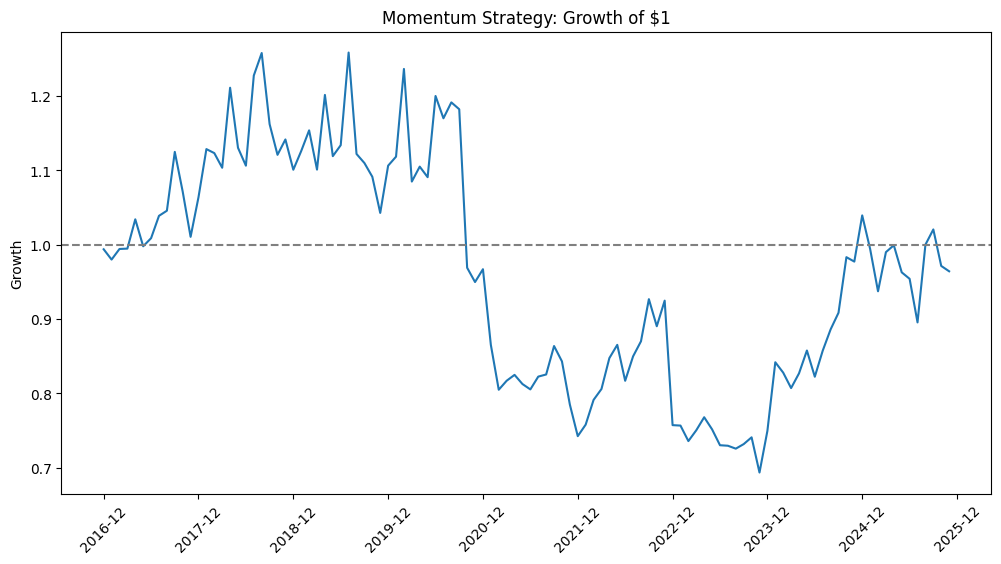

In [120]:
plt.figure(figsize=(12,6))
plt.plot(cumulative_return.index.astype(str), cumulative_return.values)
plt.title("Momentum Strategy: Growth of $1")
plt.axhline(y=1, color='gray', linestyle='--')
plt.xticks(cumulative_return.index.astype(str)[::12],rotation=45)
plt.ylabel("Growth")
plt.savefig("charts/SP500_long_short_growth.png")
plt.show()


In [ ]:
"""~~~~~~~Statistics~~~~~~~"""
rf = 0.035 # risk-free rate
# Max Drawdown
running_max = cumulative_return.cummax() 
drawdown = (cumulative_return - running_max) / running_max

max_drawdown = drawdown.min()

# Sharpe Ratio
monthly_mean = average_return.mean()   
monthly_std = average_return.std()    

annual_return = monthly_mean * 12              # annualize return
annual_vol = monthly_std * (12 ** 0.5)         # annualize volatility

long_short_sharpe = (annual_return - rf) / annual_vol

print(f"Long-Short Maximum Drawdown: {max_drawdown:.2%}")
print(f"Long-Short Sharpe Ratio: {long_short_sharpe:.2f}")



Long-Short Maximum Drawdown: -44.88%
Long-Short Sharpe Ratio: -0.11


In [ ]:
# Compare our backtest against our benchmark
import yfinance as yf
spy = yf.Ticker("SPY")
spy_hist = spy.history(period="10y", interval = "1mo")


In [ ]:
# How does our long-short compare against the benchmark?
spy_hist["Percentage Change"] = spy_hist["Close"].pct_change()
spy_returns = spy_hist.dropna()
spy_returns.index = spy_returns.index.strftime("%Y-%m")
spy_cumulative = (1 + spy_returns["Percentage Change"]).cumprod()
# Convert SPY index to Period
spy_cumulative.index = pd.to_datetime(spy_cumulative.index).to_period("M")

# Filter SPY to match momentum date range
start = cumulative_return.index.min()
end = cumulative_return.index.max()
spy_cumulative = spy_cumulative[(spy_cumulative.index >= start) & (spy_cumulative.index <= end)]

# Re-normalize so it starts at $1
spy_cumulative = spy_cumulative / spy_cumulative.iloc[0]

# SPY Drawdown
spy_running_max = spy_cumulative.cummax()
spy_drawdown = (spy_cumulative - spy_running_max) / spy_running_max
max_spy_drawdown = spy_drawdown.min()

spy_mean = spy_returns["Percentage Change"].mean()
spy_std_dev = spy_returns["Percentage Change"].std()
spy_sharpe = ((spy_mean * 12) - rf) / (spy_std_dev * (12 ** 0.5))

print(f"SPY Sharpe Ratio: {spy_sharpe:.2f}")
print(f"SPY Max Drawdown: {max_spy_drawdown:.2%}")
print(f"SPY return on investment: {((spy_cumulative.iloc[-1] - spy_cumulative.iloc[0])/spy_cumulative.iloc[0]):.2%}")



SPY Sharpe Ratio: 0.79
SPY Max Drawdown: -23.97%
SPY return on investment: 254.30%


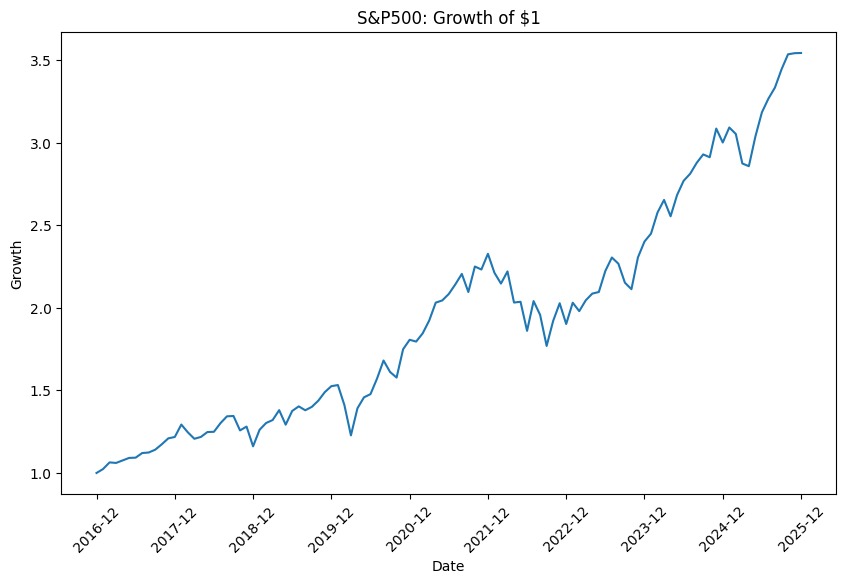

In [121]:
plt.figure(figsize=(10,6))
plt.plot(spy_cumulative.index.astype(str), spy_cumulative.values)
plt.xticks(spy_cumulative.index.astype(str)[::12], rotation=45)
plt.title("S&P500: Growth of $1")
plt.xlabel("Date")
plt.ylabel("Growth")
plt.show()

In [116]:
# How would a long-only winner's portfolio perform?
long_only_mean = winners_returns.mean()
long_only_std_dev = winners_returns.std()

long_only_sharpe = (long_only_mean * 12 - rf) / (long_only_std_dev * (12 ** 0.5))

long_only_cumulative = (1 + winners_returns).cumprod()
long_only_cumulative = long_only_cumulative.dropna()
long_only_running_max = long_only_cumulative.cummax()
long_only_drawdown = (long_only_cumulative - long_only_running_max) / long_only_running_max
long_only_max_drawdown = long_only_drawdown.min()

print(f"Long-Only Sharpe: {long_only_sharpe: .2f}")
print(f"Long-Only Max Drawdown: {long_only_max_drawdown: .2%}")
print(f"Long-Only return on investment: {(long_only_cumulative.iloc[-1] - long_only_cumulative.iloc[0]) / long_only_cumulative.iloc[0]:.2%}")


Long-Only Sharpe:  0.93
Long-Only Max Drawdown: -20.83%
Long-Only return on investment: 486.47%


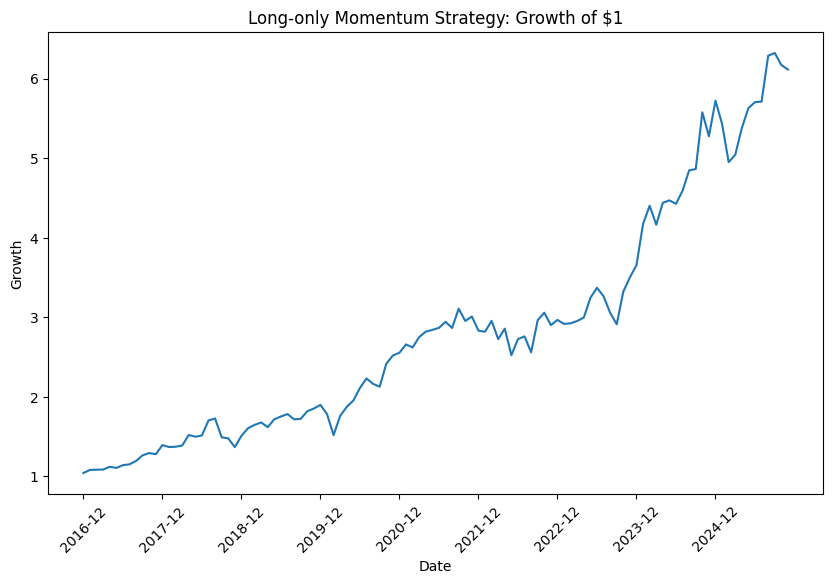

In [119]:
# Long-Only figure
plt.figure(figsize=(10,6))
plt.plot(long_only_cumulative.index.astype(str), long_only_cumulative.values)
plt.title("Long-only Momentum Strategy: Growth of $1")
plt.xticks(long_only_cumulative.index.astype(str)[::12], rotation=45)
plt.xlabel("Date")
plt.ylabel("Growth")
plt.savefig("charts/long_only_growth.png")
plt.show()

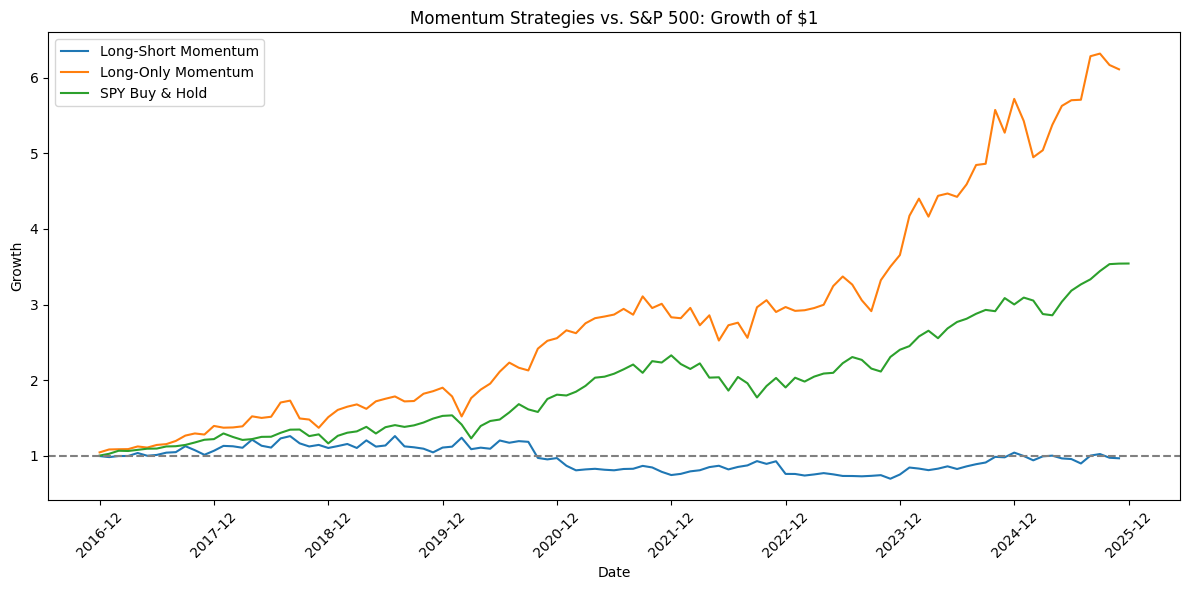

In [ ]:
# All three plots, together.
plt.figure(figsize=(12,6))
plt.plot(cumulative_return.index.astype(str), cumulative_return.values, label="Long-Short Momentum")
plt.plot(long_only_cumulative.index.astype(str), long_only_cumulative.values, label="Long-Only Momentum")
plt.plot(spy_cumulative.index.astype(str), spy_cumulative.values, label="SPY Buy & Hold")
plt.axhline(y=1, color='gray', linestyle='--')
plt.title("Momentum Strategies vs. S&P 500: Growth of $1")
plt.xticks(cumulative_return.index.astype(str)[::12], rotation=45)
plt.xlabel("Date")
plt.ylabel("Growth")
plt.legend()
plt.tight_layout()
plt.savefig("charts/momentum_vs_spy.png")
plt.show()